# Practica 8 - Transformada de Fourier de tiempo corto

**Author:** Cristian David Araujo A.

**ID:** 1089568350

**Date:** 23/10/2024

## Carga y visualización de la señal

Cargue, normalice, grafique y escuche las señales compartidas (senal1.wav y senal2.wav).

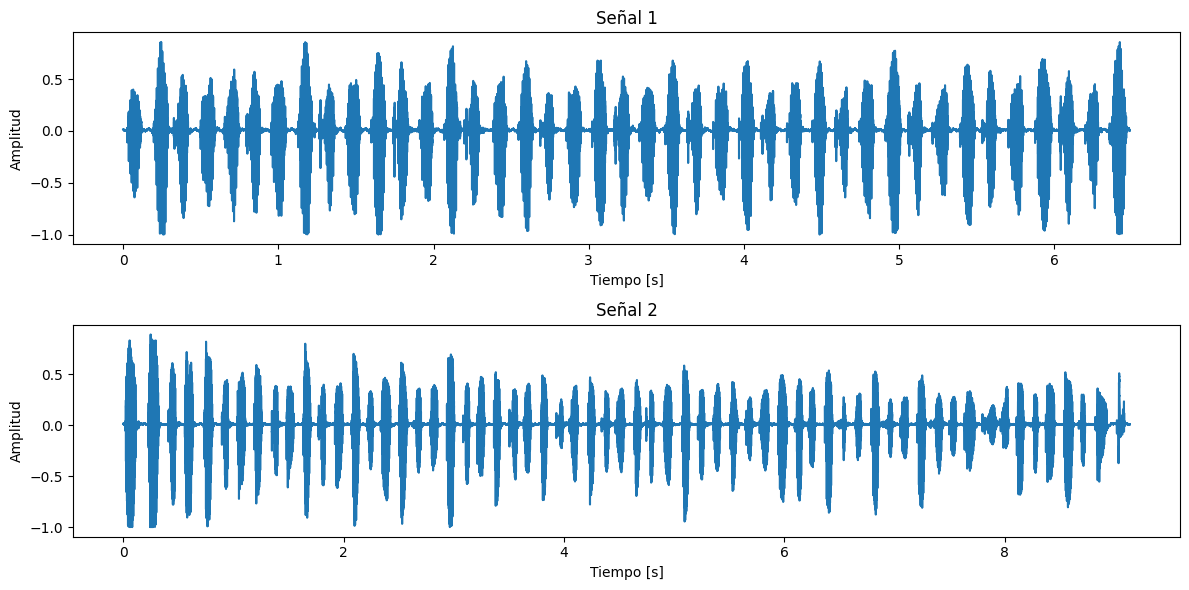

Señal 1


Señal 2


In [48]:
#Cargue, normalice, grafique y escuche las señales compartidas (senal1.wav y senal2.wav).

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as waves
from IPython.display import Audio

#Carga de señales
muestreo1, senal1 = waves.read('senal1.wav')
muestreo2, senal2 = waves.read('senal2.wav')

#Normalización de señales
senal1 = senal1 / np.max(np.abs(senal1))
senal2 = senal2 / np.max(np.abs(senal2))

#Vector de tiempo
t1 = np.linspace(0, len(senal1)/muestreo1, num=len(senal1))
t2 = np.linspace(0, len(senal2)/muestreo2, num=len(senal2))


#Gráfico de señales Magnitud vs tiempo
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t1, senal1)
plt.title('Señal 1')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.subplot(2,1,2)
plt.plot(t2, senal2)
plt.title('Señal 2')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.tight_layout()
plt.show()


#Reproducción de señales en el notebook
print('Señal 1')
display(Audio(senal1, rate=muestreo1))
print('Señal 2')
display(Audio(senal2, rate=muestreo2))


## Extracción de segmentos

También llamado enventanado y es el proceso mediante el cual se segmenta una señal en N ventanas para luego
aplicarle la STFT. Use la función mostrada a continuación y segmente su señal con un tamaño de ventana de 40 ms.
Para este punto elija solo una de las dos señales.

Dimensiones de las ventanas: (644, 640)


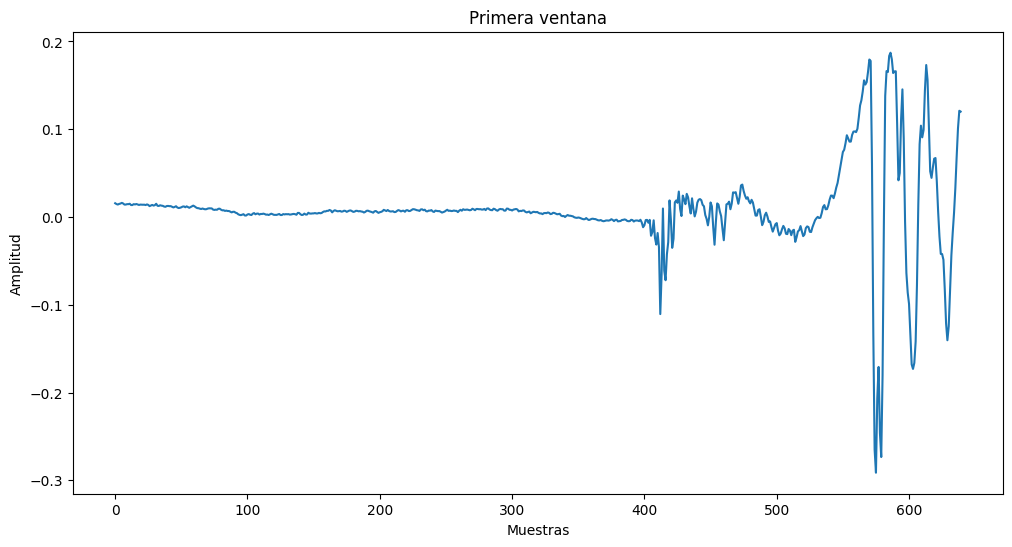

In [49]:
#Use la función mostrada a continuación y segmente su señal con un tamaño de ventana de 40 ms. Para este punto elija solo una de las dos señales.
def extraer_ventanas(signal, size, fs):
    #Tamano de paso
    step=int(0.010*fs)
    n_seg = int((len(signal) - size) / step)
    # extraer segmentos
    windows = [signal[i * step : i * step + size] for i in range(n_seg)]
    # stack (cada fila es una ventana)
    return np.vstack(windows)


#Segmentación de señal 1
ventanas1 = extraer_ventanas(senal1, int(0.040*muestreo1), muestreo1)
print('Dimensiones de las ventanas:', ventanas1.shape)

#Gráfico de la primera ventana
plt.figure(figsize=(12,6))
plt.plot(ventanas1[0])
plt.title('Primera ventana')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()



## Aplicación de ventanas

Existen diferentes tipos de ventanas como Hamming, Hanning, Blackman, a través de las cuales se puede establecer
el grado de resolución tanto de tiempo como de frecuencia que se desee. Si la ventana es muy angosta analizaremos
una porción muy pequeña de la señal lo que nos permite tener una buena resolución en tiempo, pero una mala
resolución en frecuencia, ya que conoceremos solo una mı́nima fracción del espectro total de la señal. Por otro lado,
si la ventana es muy ancha tendremos una buena resolución en frecuencia pero una mala resolución en tiempo.

### 1. Consulte como se construye y se aplica una ventana Hamming a una señal. ¿Qué tamaño de ventana debe usar?

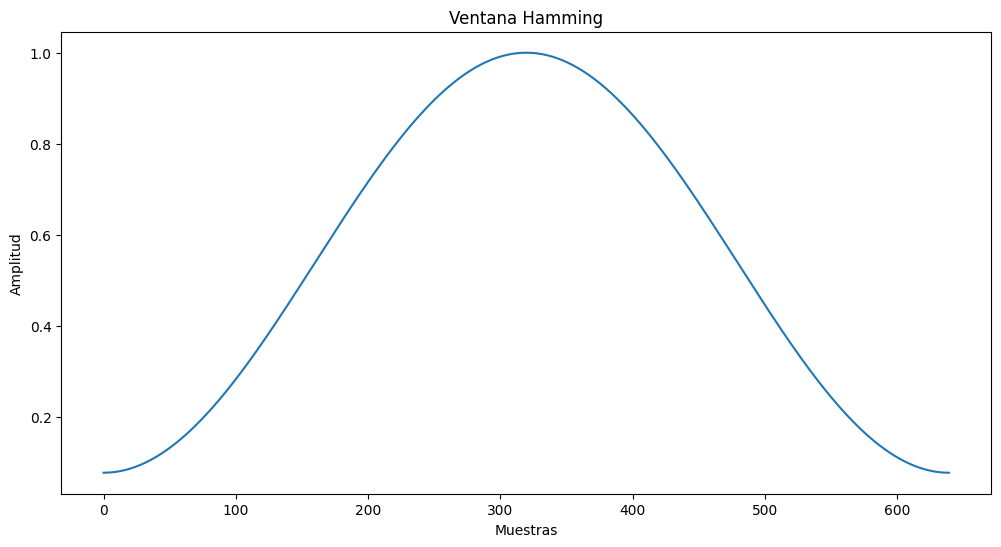

Tamaño de ventana: 640
Tamaño de ventana 2: 640


In [50]:
### Consulte como se construye y se aplica una ventana Hamming a una señal. ¿Qué tamaño de ventana debe usar?

#Construcción de ventana Hamming
def hamming(size):
    return 0.53836 - 0.46164*np.cos(2*np.pi*np.arange(size)/(size-1))

#Gráfico de ventana Hamming 
plt.figure(figsize=(12,6))
plt.plot(hamming(int(0.040*muestreo1)))
plt.title('Ventana Hamming')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()

#Tamaño de ventana
size_ventana1 = int(0.040*muestreo1)
print('Tamaño de ventana:', size_ventana1)

#Tamaño de ventana 2
size_ventana2 = int(0.040*muestreo2)
print('Tamaño de ventana 2:', size_ventana2)


La ventana Hamming es una ventana de tamaño 40 ms, ya que es el tamaño de ventana que se está utilizando para segmentar la señal. Esta ventana se aplica multiplicando elemento a elemento con la señal segmentada.

La ecuación de la ventana Hamming es: w(n) = 0.53836 - 0.46164*cos(2*pi*n/(N-1)), donde N es el tamaño de la ventana y n es el índice de la ventana.

### 2. Aplique la ventana construida para cada uno de los segmentos extraı́dos anteriormente.

In [51]:
### Aplique la ventana construida para cada uno de los segmentos extraı́dos anteriormente.

#Aplicación de ventana Hamming
ventanas1_hamming = ventanas1 * hamming(size_ventana1)

### 3. Usando un subplot, grafique un segmento antes y después de aplicarle la ventana Hanning. ¿Observa alguna diferencia? Explique.

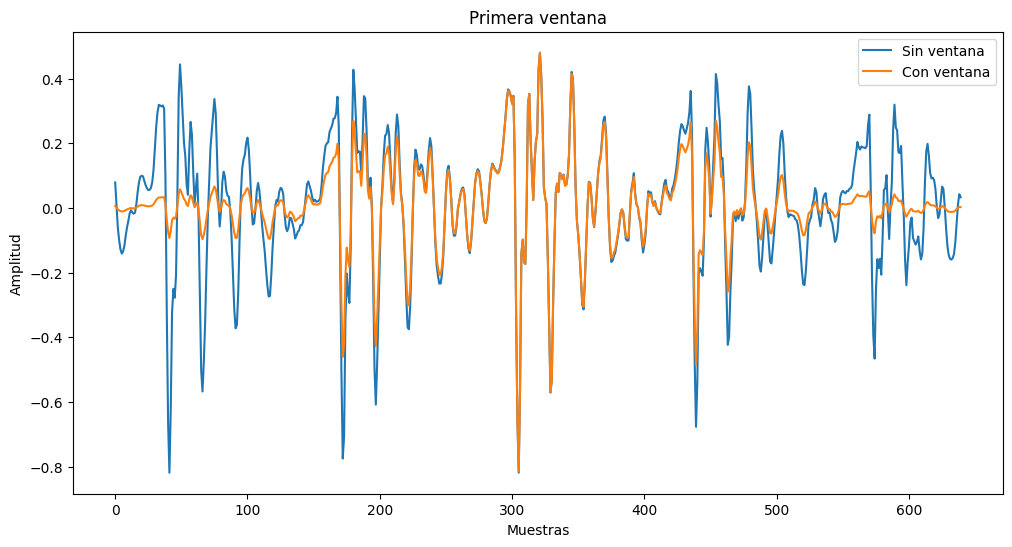

In [52]:
#Gráfico la ventana 100 sin y con ventana Hamming
plt.figure(figsize=(12,6))
plt.plot(ventanas1[100], label='Sin ventana')
plt.plot(ventanas1_hamming[100], label='Con ventana')
plt.title('Primera ventana')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.show()



En la grafica del enventanado se observa que la ventana Hamming suaviza los extremos de la señal, lo que permite reducir el efecto de las discontinuidades en los bordes de la ventana.

## Aplicación de la STFT

### 1. Usando la siguiente función calcule la STFT a cada uno de los segmentos del ı́tem anterior, para esto use un tamaño de NFFT de 512.

In [53]:
### 1. Usando la siguiente función calcule la STFT a cada uno de los segmentos del ı́tem anterior, para esto use un tamaño de NFFT de 512.

def potspec(X, size, n_padded_min=0):
    # Zero padding
    n_padded = 0
    if n_padded_min==0:
        n_padded = max(n_padded_min, int(2 ** np.ceil(np.log(size) / np.log(2))))
    else:
        n_padded = n_padded_min
    # Transformada de Fourier
    Y = np.fft.fft(X, n=n_padded)
    Y = np.absolute(Y)
    # non-redundant part
    m = int(n_padded / 2) + 1
    Y = Y[:, :m]
    Img=Y.imag
    Real=Y.real
    spec= np.sqrt(Real**2+ Img**2)
    return spec, n_padded

espectro1, n_padded = potspec(ventanas1_hamming, size_ventana1, 512)
espectro1 = np.flipud(10*np.log10(espectro1).T)


### 2. Grafique la representación tiempo-frecuencia obtenida en el ı́tem anterior.

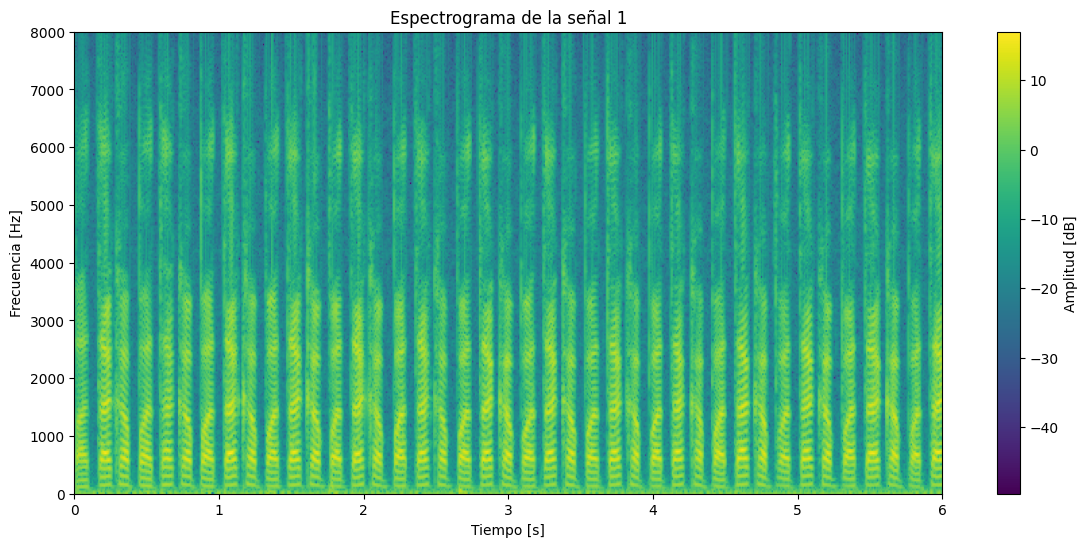

In [57]:
### 2. Grafique la representación tiempo-frecuencia obtenida en el ı́tem anterior.

plt.figure(figsize=(14,6))
plt.imshow(espectro1, aspect='auto', extent=[0, len(senal1)//muestreo1, 0, muestreo1//2])
plt.title('Espectrograma de la señal 1')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.colorbar(label='Amplitud [dB]')
plt.show()


### 3.Qué puede concluir del espectrograma? ¿En qué intervalos de frecuencia está definida la señal? Explique.

La mayoría de la energía de la señal se encuentra en la banda de frecuencias de 0 a 3kHz, esto se debe a que la señal es de voz humana y la mayoría de los fonemas se encuentran en esta banda de frecuencias.

### 4. Calcule y grafique la STFT para valores de NFFT equivalentes a 64, 1024 y 4096. ¿Qué diferencia encuentra al variar este tamaño? ¿A su criterio cuál es el tamaño de NFFT que tiene una mejor resolución tiempo-frecuencia? Explique.

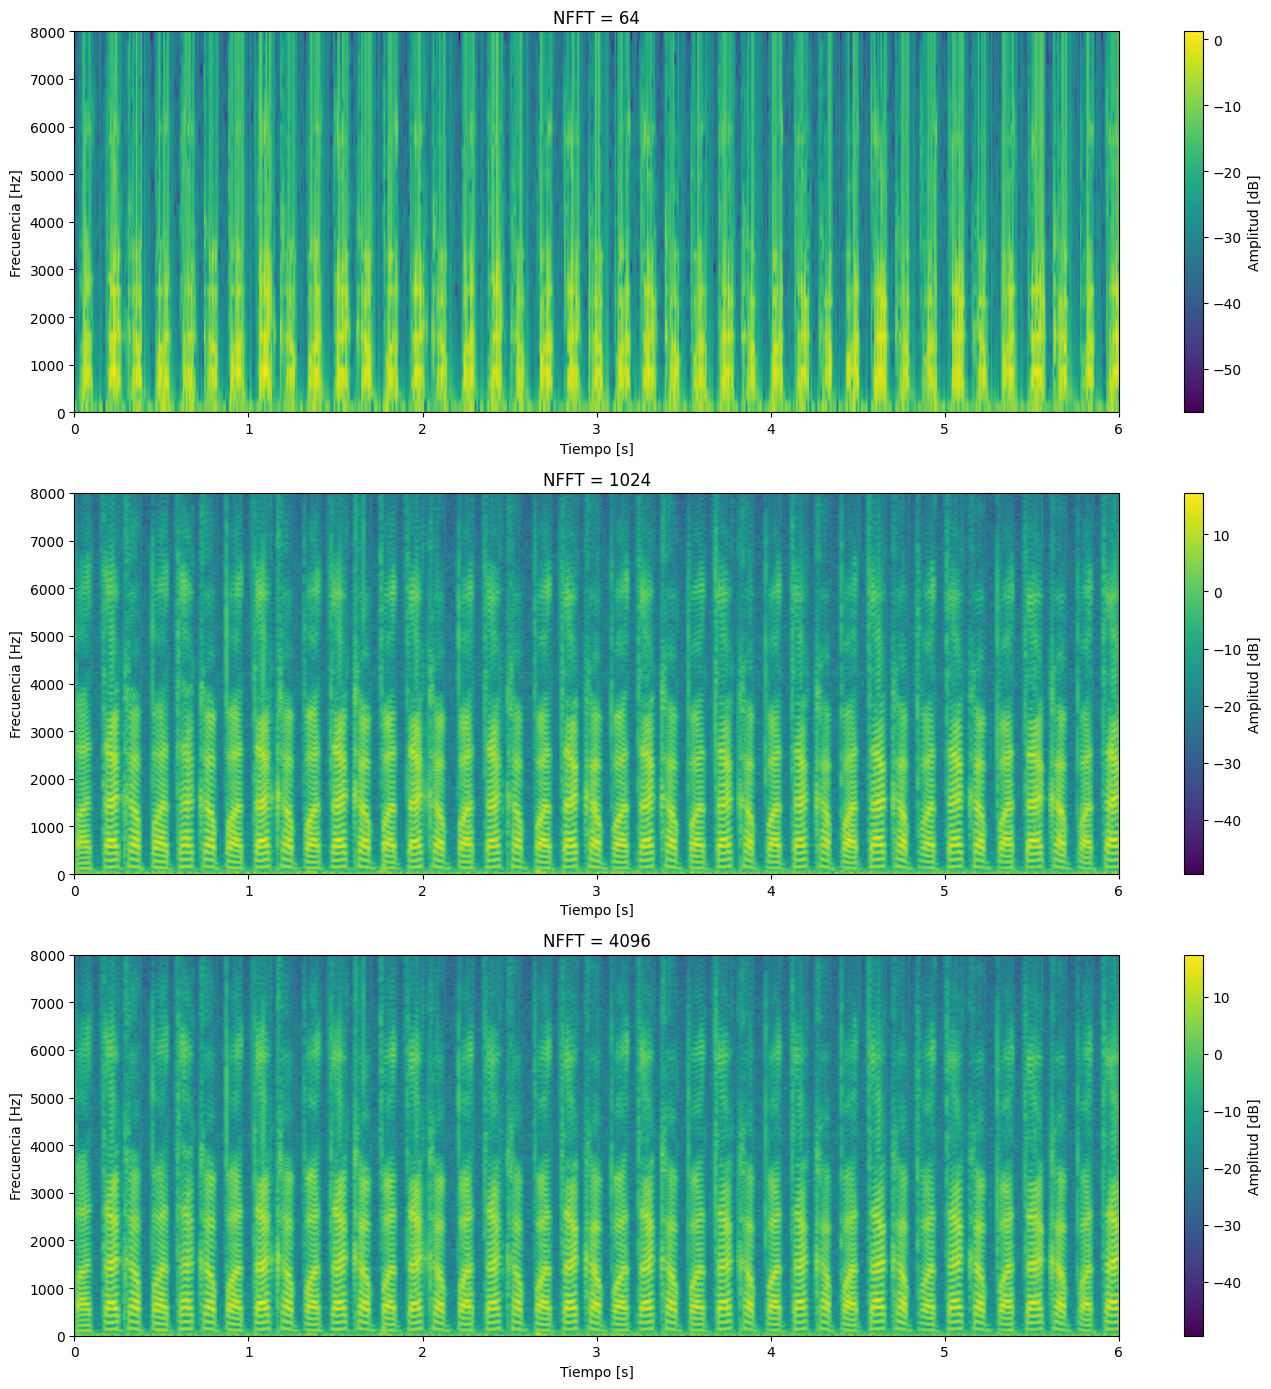

In [64]:
### 4. Calcule y grafique la STFT para valores de NFFT equivalentes a 64, 1024 y 4096. ¿Qué diferencia encuentra al variar este tamaño? ¿A su criterio cuál es el tamaño de NFFT que tiene una mejor resolución tiempo-frecuencia? Explique.

#Arreglo de NFFT
NFFT = [64, 1024, 4096]

#Cálculo de STFT
espectros = [potspec(ventanas1_hamming, size_ventana1, nfft) for nfft in NFFT]
espectros = [(np.flipud(10*np.log10(espectro).T), nfft) for espectro, nfft in espectros]

#Gráfico de STFT
plt.figure(figsize=(14,14))
for espectro, nfft in espectros:
    plt.subplot(3,1,NFFT.index(nfft)+1)
    plt.imshow(espectro, aspect='auto', extent=[0, len(senal1)//muestreo1, 0, muestreo1//2])
    plt.title('NFFT = {}'.format(nfft))
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Frecuencia [Hz]')
    plt.colorbar(label='Amplitud [dB]')

plt.tight_layout()
plt.show()

La diferencia al variar el tamaño de NFFT es la resolución en frecuencia y tiempo. A mayor tamaño de NFFT, mayor resolución en frecuencia y menor resolución en tiempo. A menor tamaño de NFFT, menor resolución en frecuencia y mayor resolución en tiempo. En este caso se considera que con 1024 se tiene una mejor resolución tiempo-frecuencia, ya que se puede observar con claridad la variación de la señal en el tiempo y en la frecuencia. Aunmentar este valor no aporta mayor información y disminuirlo no permite observar con claridad la variación de la señal en el tiempo y en la frecuencia.

### 5. Con la mejor resolución del numeral anterior, grafique las dos señales. ¿Qué se puede concluir? ¿En que se diferencian?

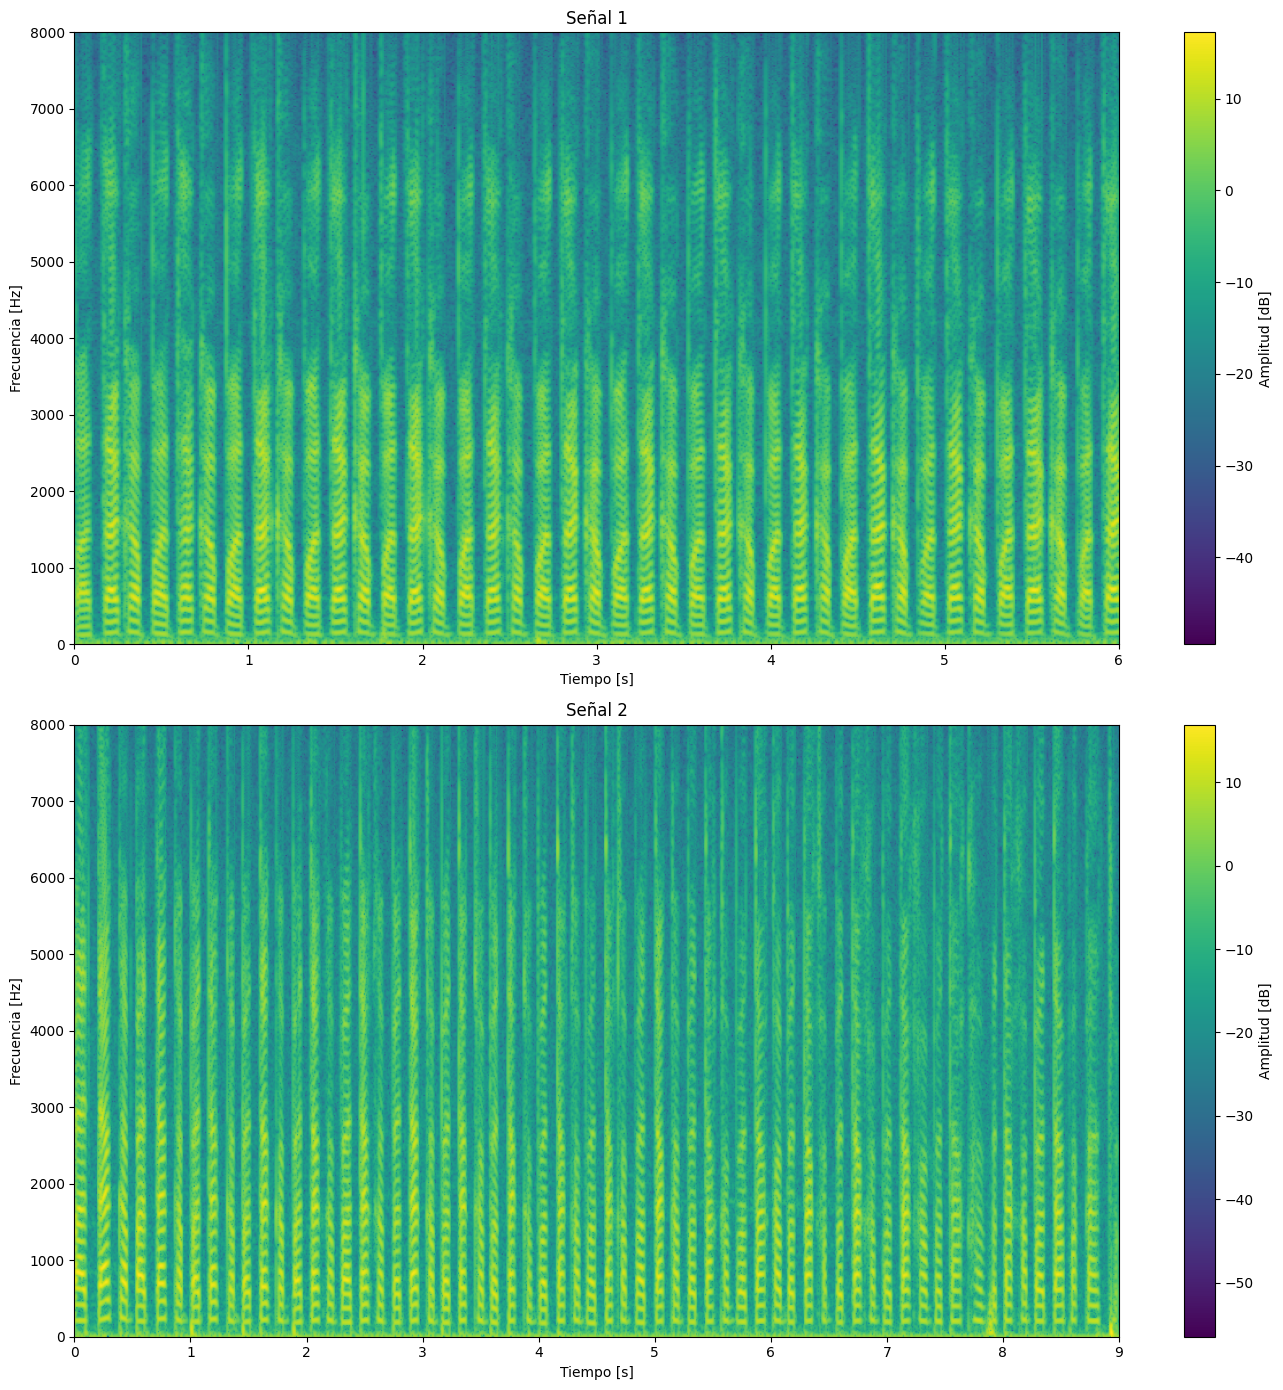

In [67]:
### 5. Con la mejor resolución del numeral anterior, grafique las dos señales. ¿Qué se puede concluir? ¿En que se diferencian?

#Mejor resolución
best_res = 1024

#Cálculo de STFT de las dos señales
ventanas2 = extraer_ventanas(senal2, int(0.040*muestreo2), muestreo2)
ventanas2_hamming = ventanas2 * hamming(size_ventana2)
espectro2, _ = potspec(ventanas2_hamming, size_ventana2, best_res)
espectro2 = np.flipud(10*np.log10(espectro2).T)

ventanas1 = extraer_ventanas(senal1, int(0.040*muestreo1), muestreo1)
ventanas1_hamming = ventanas1 * hamming(size_ventana1)
espectro1, _ = potspec(ventanas1_hamming, size_ventana1, best_res)
espectro1 = np.flipud(10*np.log10(espectro1).T)

#Gráfico de STFT de las dos señales
plt.figure(figsize=(14,14))
plt.subplot(2,1,1)
plt.imshow(espectro1, aspect='auto', extent=[0, len(senal1)//muestreo1, 0, muestreo1//2])
plt.title('Señal 1')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.colorbar(label='Amplitud [dB]')
plt.subplot(2,1,2)
plt.imshow(espectro2, aspect='auto', extent=[0, len(senal2)//muestreo2, 0, muestreo2//2])
plt.title('Señal 2')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.colorbar(label='Amplitud [dB]')
plt.tight_layout()
plt.show()


En la señal 2 a diferencia de la señal 1 se evidencia que su rando de distribución de mayor energía es más amplio, es decir, la señal 2 tiene una mayor cantidad de frecuencias presentes en su espectrograma. Esto se debe a que la señal 2 es una voz femenina, la cual tiene un rango de frecuencias más amplio que la señal 1, la cual es una voz masculina. Por lo tanto, la señal 2 tiene una mayor cantidad de armónicos de altaa frecuencia presentes en su espectrograma.

## Conclusiones

Los espectrogramas generados mediante la STFT son herramientas clave en el campo del aprendizaje automático, especialmente para el reconocimiento de patrones. Su representación visual de las frecuencias a lo largo del tiempo es ideal para ser procesada por redes neuronales convolucionales, permitiendo aplicaciones en reconocimiento de voz, clasificación de sonidos y análisis musical.

La implementación de la escala de Mel en los espectrogramas mejora la representación de las señales sonoras, alineándolas más estrechamente con la percepción humana del sonido. Esto es crucial para aplicaciones como el reconocimiento de voz y música, donde la audibilidad es fundamental. Además, se ha demostrado que esta escala facilita el entrenamiento de modelos al hacer que las características sonoras sean más discriminativas.

El uso de ventanas en la STFT es esencial para reducir las fugas espectrales, que pueden introducir artefactos en el análisis. Estrategias como la ventana de Hamming ayudan a mitigar estos efectos, permitiendo un análisis más preciso de las componentes de la señal. La elección de la ventana adecuada puede influir significativamente en la calidad del espectrograma y en la interpretación de los resultados.

Gracias a la concentración de energía en el espectrograma, es posible inferir características de la voz, como el género, sin necesidad de escuchar el audio. Esto se basa en la distribución de la energía en diferentes frecuencias, lo que ofrece una forma efectiva de clasificación. Esta capacidad de análisis permite aplicaciones en sistemas de reconocimiento de voz y en la mejora de interfaces de usuario.

La STFT y los espectrogramas son herramientas valiosas no solo para el análisis de audio, sino también para el monitoreo en tiempo real del espectro de frecuencias en telecomunicaciones. Permiten a los operadores identificar interferencias, detectar señales no autorizadas y optimizar el uso del espectro radioeléctrico, lo que es crucial para garantizar una comunicación clara y efectiva. En entornos críticos, como emergencias o defensa, esta capacidad de visualización instantánea facilita la identificación rápida de amenazas y la gestión proactiva de recursos, mejorando tanto la calidad del servicio como la seguridad operativa.

Con el avance de las técnicas de deep learning y el aumento de la capacidad computacional, los modelos que utilizan espectrogramas han alcanzado niveles de precisión sorprendentes en tareas como la identificación de locutores, la detección de emociones en la voz y la separación de fuentes sonoras.